## NLP Assignment : Spam Filter
### Minju Jo

### 1. Import necessary libs and datasets

In [1]:
import numpy as np
import pandas as pd
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [2]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data['text'] = data['v2']
data['isSpam'] = data['v1']

del data['v1'], data['v2']

print(f'Data Shape: {data.shape}')
# imbalanced data
print(data['isSpam'].value_counts())
data.head()

Data Shape: (5572, 2)
0    4825
1     747
Name: isSpam, dtype: int64


,text,isSpam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


### 2. Train, Test Split

In [3]:
from sklearn.model_selection import train_test_split

X, y = data['text'], data['isSpam']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,
                                                   stratify=y, test_size=0.1)

print(len(X_train), len(X_test))

5014 558


In [4]:
y_train.value_counts()

0    4342
1     672
Name: isSpam, dtype: int64

### 3. Preprocessing

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
train = pd.DataFrame(X_train)
train["isSpam"] = y_train
train.head()

,text,isSpam
5448,"aight we can pick some up, you open before ton...",0
1707,Was doing my test earlier. I appreciate you. W...,0
2117,Wish u many many returns of the day.. Happy bi...,0
1357,Good afternoon loverboy ! How goes you day ? A...,0
787,Ever thought about living a good life with a p...,1


#### length of text

In [7]:
train["text_len"] = train["text"].str.len()
train.head()

,text,isSpam,text_len
5448,"aight we can pick some up, you open before ton...",0,51
1707,Was doing my test earlier. I appreciate you. W...,0,68
2117,Wish u many many returns of the day.. Happy bi...,0,60
1357,Good afternoon loverboy ! How goes you day ? A...,0,152
787,Ever thought about living a good life with a p...,1,129


In [8]:
train.groupby("isSpam").mean()

,text_len
isSpam,
0,71.015891
1,138.398810


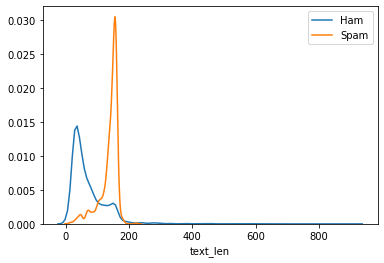

In [9]:
sns.distplot(train["text_len"][train["isSpam"] == 0], hist = False, label = "Ham")
sns.distplot(train["text_len"][train["isSpam"] == 1], hist = False, label = "Spam")

#### ? rate

In [10]:
ham_que = train["text"][train["isSpam"]==0].str.count("/?")/train["text"][train["isSpam"]==0].str.len()
spam_que = train["text"][train["isSpam"]==1].str.count("/?")/train["text"][train["isSpam"]==1].str.len()

In [11]:
ham_que.mean()

1.0238417414318988

In [12]:
spam_que.mean()

1.0080437381261151

no diff

#### ! rate

In [13]:
ham_punc = train["text"][train["isSpam"]==0].str.count("!")/train["text"][train["isSpam"]==0].str.len()
spam_punc = train["text"][train["isSpam"]==1].str.count("!")/train["text"][train["isSpam"]==1].str.len()

In [14]:
ham_punc.mean()

0.0023606525305321117

In [15]:
spam_punc.mean()

0.005338244766483763

In [16]:
train["punc"] = train["text"].str.count("!")

#### capital letter rate

In [17]:
import re

In [18]:
ham_rate = train["text"][train["isSpam"]==0].str.findall(r'[A-Z]').str.len()/train["text"][train["isSpam"]==0].str.len()
spam_rate = train["text"][train["isSpam"]==1].str.findall(r'[A-Z]').str.len()/train["text"][train["isSpam"]==1].str.len()

In [19]:
ham_rate.mean()

0.05920248633072524

In [20]:
spam_rate.mean()

0.1115573824148606

In [21]:
train["cap_rate"] = train["text"].str.findall(r'[A-Z]').str.len()/train["text"].str.len()

#### comparison - tfidf

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
vectorizer = TfidfVectorizer(max_features = 100)
vector = vectorizer.fit_transform(train["text"][train["isSpam"] == 1])

In [24]:
spam_lst = vectorizer.vocabulary_.keys()

In [25]:
vectorizer = TfidfVectorizer(max_features = 100)
vector = vectorizer.fit_transform(train["text"][train["isSpam"] == 0])

In [26]:
ham_lst = vectorizer.vocabulary_.keys()

In [27]:
for word in spam_lst:
    if word not in ham_lst:
        print(word)

txt
mobile
sms
win
1000
our
150p
msg
customer
been
receive
free
ringtone
reply
message
cash
every
wk
www
mins
draw
100
camera
awarded
landline
contact
won
prize
claim
per
rate
week
new
nokia
phone
video
18
uk
com
text
chat
please
latest
code
cs
50
min
500
co
po
box
urgent
tone
service
guaranteed
number
has
line
150ppm
16
stop
holiday
find
who
000


#### number rate

In [28]:
ham_num = train["text"][train["isSpam"]==0].str.findall(r'[0-9]').str.len()/train["text"][train["isSpam"]==0].str.len()
spam_num = train["text"][train["isSpam"]==1].str.findall(r'[0-9]').str.len()/train["text"][train["isSpam"]==1].str.len()

In [29]:
ham_num.mean()

0.0040541994666673875

In [30]:
spam_num.mean()

0.11692788868534248

In [31]:
train["num_rate"] = train["text"].str.findall(r'[0-9]').str.len()/train["text"].str.len()

In [32]:
train.head()

,text,isSpam,text_len,punc,cap_rate,num_rate
5448,"aight we can pick some up, you open before ton...",0,51,0,0.000000,0.000000
1707,Was doing my test earlier. I appreciate you. W...,0,68,0,0.044118,0.000000
2117,Wish u many many returns of the day.. Happy bi...,0,60,0,0.033333,0.000000
1357,Good afternoon loverboy ! How goes you day ? A...,0,152,1,0.026316,0.000000
787,Ever thought about living a good life with a p...,1,129,0,0.093023,0.023256


In [33]:
def preprocess(df):
    df["text"] = df["text"].str.lower()
    df["text_len"] = df["text"].str.len()
    df["punc"] = df["text"].str.count("!")
    df["cap_rate"] = df["text"].str.findall(r'[A-Z]').str.len()/df["text"].str.len()
    df["num_rate"] = df["text"].str.findall(r'[0-9]').str.len()/df["text"].str.len()
    
    return df


In [34]:
preprocessed_train = preprocess(train)

In [35]:
preprocessed_train.head()

,text,isSpam,text_len,punc,cap_rate,num_rate
5448,"aight we can pick some up, you open before ton...",0,51,0,0.0,0.000000
1707,was doing my test earlier. i appreciate you. w...,0,68,0,0.0,0.000000
2117,wish u many many returns of the day.. happy bi...,0,60,0,0.0,0.000000
1357,good afternoon loverboy ! how goes you day ? a...,0,152,1,0.0,0.000000
787,ever thought about living a good life with a p...,1,129,0,0.0,0.023256


### 4. Tokenizing & Vocab Dict

In [36]:
from nltk import stem
from nltk.corpus import stopwords
stemmer = stem.SnowballStemmer('english')
stopwords = set(stopwords.words('english'))

In [37]:
def tokenize(txt):
    txt = re.sub('[^\w\s]', ' ', txt)
    txt = re.sub('\d+', ' ', txt)
    txt = [word for word in txt.split() if word not in stopwords]
    txt = " ".join([stemmer.stem(word) for word in txt])
    return txt

In [38]:
preprocessed_train["text"] = preprocessed_train["text"].apply(tokenize)

In [39]:
preprocessed_train.head()

,text,isSpam,text_len,punc,cap_rate,num_rate
5448,aight pick open tonight,0,51,0,0.0,0.000000
1707,test earlier appreci call tomorrow,0,68,0,0.0,0.000000
2117,wish u mani mani return day happi birthday vikki,0,60,0,0.0,0.000000
1357,good afternoon loverboy goe day luck come way ...,0,152,1,0.0,0.000000
787,ever thought live good life perfect partner tx...,1,129,0,0.0,0.023256


In [40]:
vectorizer = TfidfVectorizer(max_features = 150)
train_vector = vectorizer.fit_transform(preprocessed_train["text"])

In [41]:
vectorizer.vocabulary_

{'pick': 88,
 'tonight': 125,
 'call': 12,
 'tomorrow': 123,
 'wish': 142,
 'day': 25,
 'happi': 45,
 'good': 40,
 'come': 20,
 'way': 137,
 'think': 120,
 'send': 99,
 'love': 64,
 'make': 66,
 'smile': 104,
 'live': 60,
 'life': 58,
 'txt': 127,
 'back': 9,
 'mobil': 71,
 'let': 57,
 'know': 53,
 'lol': 61,
 'finish': 33,
 'meet': 67,
 'special': 109,
 'win': 141,
 'take': 114,
 'go': 39,
 'msg': 74,
 'also': 1,
 'said': 96,
 'start': 110,
 'around': 5,
 'sorri': 108,
 'help': 46,
 'leav': 56,
 'week': 138,
 'new': 77,
 'gt': 43,
 'work': 143,
 'hi': 48,
 'lt': 65,
 'contact': 21,
 'www': 145,
 'com': 19,
 'great': 42,
 'place': 89,
 'free': 35,
 'ok': 83,
 'thing': 119,
 'time': 121,
 'year': 147,
 'alreadi': 0,
 'get': 37,
 'lor': 63,
 'pleas': 90,
 'phone': 87,
 'say': 97,
 'give': 38,
 'miss': 70,
 'someon': 105,
 'would': 144,
 'like': 59,
 'pls': 91,
 'right': 95,
 'amp': 3,
 'wait': 133,
 'person': 86,
 'even': 29,
 'repli': 94,
 'messag': 68,
 'one': 84,
 'look': 62,
 'oh': 8

vocab dictionary

### 5.Test dataset

In [42]:
test = pd.DataFrame(X_test)
preprocessed_test = preprocess(test)
preprocessed_test["text"] = preprocessed_test["text"].apply(tokenize)
test_vector = vectorizer.transform(preprocessed_test["text"])

In [43]:
train_vector = train_vector.toarray()
test_vector = test_vector.toarray()

In [44]:
train_vector.shape

(5014, 150)

In [45]:
test_vector.shape

(558, 150)

In [46]:
train_names = sorted(vectorizer.vocabulary_.keys(), key=lambda x: vectorizer.vocabulary_[x])
train_tfidf = pd.DataFrame(train_vector, columns=train_names)

test_names = sorted(vectorizer.vocabulary_.keys(), key=lambda x: vectorizer.vocabulary_[x])
test_tfidf = pd.DataFrame(test_vector, columns=test_names)

In [47]:
preprocessed_train = preprocessed_train.reset_index(drop = True)
preprocessed_test = preprocessed_test.reset_index(drop = True)

In [48]:
final_train = pd.concat([train_tfidf, preprocessed_train.iloc[:, 1:]], axis = 1)
final_test = pd.concat([test_tfidf, preprocessed_test.iloc[:, 1:]], axis = 1)

In [49]:
final_train_x = final_train.loc[:, final_train.columns != 'isSpam']
final_train_y = final_train['isSpam']

In [50]:
final_train_x

,alreadi,also,alway,amp,anyth,around,ask,award,babe,back,...,would,www,yeah,year,yes,ì_,text_len,punc,cap_rate,num_rate
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,51,0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,68,0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,60,0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,152,1,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.388651,...,0.0,0.0,0.0,0.0,0.0,0.0,129,0,0.0,0.023256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,157,1,0.0,0.019108
5010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,78,0,0.0,0.000000
5011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,136,0,0.0,0.066176
5012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,44,0,0.0,0.000000


### 6. DataLoaders

In [51]:
class TrainData(Dataset):
    def __init__(self):
        self.x = torch.FloatTensor(final_train_x.values)
        self.y = torch.tensor(final_train_y.values)
        
    def __getitem__(self, s):
        return self.x[s], self.y[s]
    
    def __len__(self):
        return len(self.x)

In [52]:
class TestData(Dataset):
    def __init__(self):
        self.x = torch.FloatTensor(final_test.values)
        self.y = torch.tensor(y_test.values)
        
    def __getitem__(self, s):
        return self.x[s], self.y[s]
    
    def __len__(self):
        return len(self.x)

### 7. Modeling

In [53]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [54]:
batch_size = 200
epoch = 300

torch.manual_seed(1000)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [55]:
class SpamClassifier(nn.Module):
    def __init__(self):
        super(SpamClassifier, self).__init__()
        self.fc1 = nn.Linear(154, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 2)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout()
        self.init_weights()
    
    def init_weights(self):
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        torch.nn.init.kaiming_normal_(self.fc3.weight)
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.zeros_(self.fc2.bias)
        torch.nn.init.zeros_(self.fc3.bias)
    
    def forward(self, x):
        x = x.view(-1, x.shape[-1])
        x = self.dropout(self.fc1(x))
        x = F.relu(self.bn1(x))
        x = self.dropout(self.fc2(x))
        x = F.relu(self.bn2(x))
        x = self.fc3(x)
        return x

In [56]:
net = SpamClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [57]:
dataset = TrainData()
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [58]:
net.train()
losses = []

for i in range(1, epoch+1):
    for x, y in train_loader:
        optimizer.zero_grad()
        y_pred = net(x)
        loss = criterion(y_pred, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    if i % 10 == 0:
        print(i, " : ", np.mean(losses))
    losses = []

10  :  0.31310401742274946
20  :  0.30452786959134615
30  :  0.29671764889588725
40  :  0.288942396067656
50  :  0.2936273945065645
60  :  0.2815088297312076
70  :  0.2962151227089075
80  :  0.2875633669587282
90  :  0.28462526116233605
100  :  0.2839384921468221
110  :  0.29778631776571274
120  :  0.28733851187504256
130  :  0.276014588200129
140  :  0.28442489069241744
150  :  0.2815150727446263
160  :  0.2878282849605267
170  :  0.27544462652160573
180  :  0.2770598805867709
190  :  0.27622699852173144
200  :  0.28320490339627635
210  :  0.2751637751666399
220  :  0.2729828400680652
230  :  0.28927346204335874
240  :  0.2728160863312391
250  :  0.2768727317452431
260  :  0.2800661910038728
270  :  0.26960171357943463
280  :  0.27837980882479596
290  :  0.27684973180294037
300  :  0.2724925514597159


In [59]:
dataset = TestData()
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [60]:
correct = 0
total = 0
total_output = []

with torch.no_grad():
    for x, y in test_loader:
        outputs = net(x)
        _, predicted = torch.max(outputs.data, 1)
        total_output.extend(predicted.numpy())
        total += y.size(0)
        correct += (predicted == y).sum().item()

print('Accuracy of Spam Filter: %d %%' % (
    100 * correct / total))

Accuracy of Spam Filter: 86 %


In [61]:
total_output.count(0)

539

In [62]:
total_output.count(1)

19